**IQ Imbalance demo**
In QPSK

In [306]:
# import packages for scientific python and plotting
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline

N = 100       # number of symbols
K = 209        # filter length
n_up = 17     # oversampling 
fc = 2.3e6   # carrier frequency
sigma2t = 0.001*(1e-6)**2 # variance of jitter
T_sym = 1e-6  # Symbol duration
t = np.arange(N*n_up)*T_sym/n_up

In [307]:
def get_rrc_ir(K, n_up, t_symb, beta):
        
    ''' 
    Determines coefficients of an RRC filter 
    
    Formula out of: J. Huber, Trelliscodierung, Springer, 1992, S. 15
    At poles, values of wikipedia.de were used (without cross-checking)
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR, upsampling factor, symbol time, roll-off factor
    OUT: filter ceofficients
    '''

    assert K%2 != 0, "Filter length needs to be odd"
    if beta == 0:
        beta = 1e-32

    # init
    rrc = np.zeros(K)
    t_sample = t_symb/n_up
    
    if K%2 != 0:
        i_steps = np.arange(0,K)
        k_steps = np.arange(-(K-1)/2.0,(K-1)/2.0+1)    
        t_steps = k_steps*t_sample
        for i in i_steps:
            if t_steps[i] == 0:
                rrc[i] = 1.0/np.sqrt(t_symb)*(1.0-beta+4.0*beta/np.pi)
            elif np.abs(t_steps[i]) == t_symb/4.0/beta:
                rrc[i] = beta/np.sqrt(2.0*t_symb)*((1+2/np.pi)*np.sin(np.pi/4.0/beta)+(1.0-2.0/np.pi)*np.cos(np.pi/4.0/beta))
            else:
                rrc[i] = 1.0/np.sqrt(t_symb)*(np.sin(np.pi*t_steps[i]/t_symb*(1-beta))+4.0*beta*t_steps[i]/t_symb*np.cos(np.pi*t_steps[i]/t_symb*(1+beta)))/(np.pi*t_steps[i]/t_symb*(1.0-(4.0*beta*t_steps[i]/t_symb)**2.0))
 
    return rrc

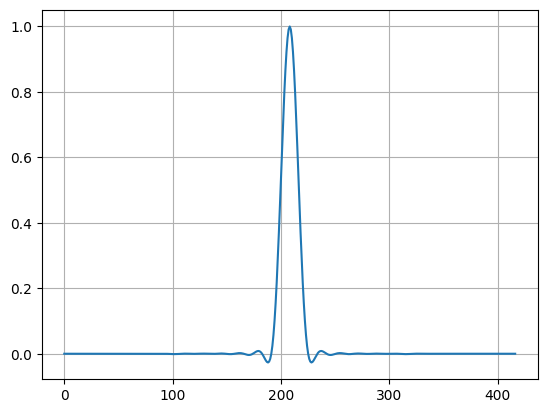

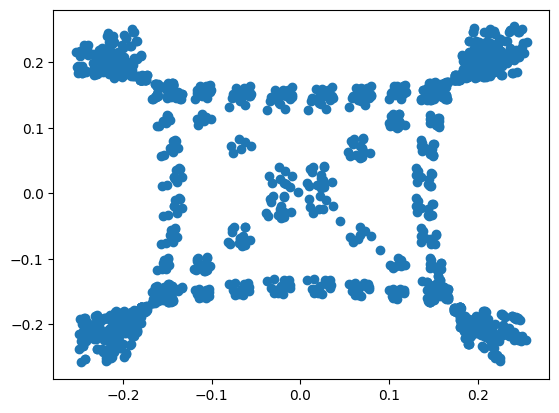

In [308]:
m = 1/np.sqrt(2)*(np.random.choice([1,-1],N) + 1j*np.random.choice([-1,1],N))
filt = get_rrc_ir(K,n_up,T_sym,1)
filt = filt/np.sqrt(np.sum(np.abs(filt)**2))

# Upsampling by factor K
s_up = np.zeros(n_up*N,complex)
s_up[::n_up] = m

s_bb = np.convolve(s_up,filt)[int((K-1)/2):-int((K-1)/2)]

x = np.real(s_bb)
y = np.imag(s_bb)

plt.figure()
plt.plot(np.convolve(filt,filt))
plt.grid()


plt.figure()
plt.scatter(x,y)
plt.show()

In [309]:
## Amplitude variantions
Ai = 1
Aq = 0.7

## Frequency variations
fi = 0 * fc
fq = 0.001 *fc

## jitter
ti = (np.random.normal(size=s_bb.shape)*np.sqrt(sigma2t))
tq = (np.random.normal(size=s_bb.shape)*np.sqrt(sigma2t))



In [310]:
## Signal with IQ-imbalance
t_new = np.arange(s_bb.shape[0])*T_sym/n_up
s_bp_ideal = np.real(s_bb)*np.cos(2*np.pi*fc*t_new)-np.imag(s_bb)*np.sin(2*np.pi*fc*t_new)
s_bp = np.real(s_bb)*Ai*np.cos(2*np.pi*(fc+fi)*(t_new+ti))-np.imag(s_bb)*Aq*np.sin(2*np.pi*(fc+fq)*(t_new+tq))

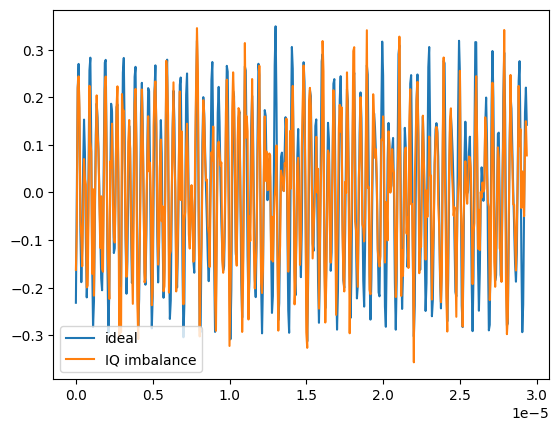

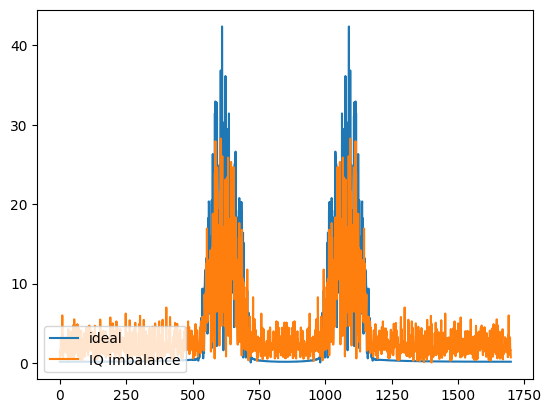

In [311]:
plt.plot(t[0:500],s_bp_ideal[0:500],label="ideal")
plt.plot(t[0:500],s_bp[0:500],label="IQ imbalance")
plt.legend(loc=3)
plt.show()

spec = np.fft.fftshift(np.fft.fft(s_bp_ideal))
spec_IQim = np.fft.fftshift(np.fft.fft(s_bp))
plt.plot(np.abs(spec),label="ideal")
plt.plot(np.abs(spec_IQim),label="IQ imbalance")
plt.legend(loc=3)

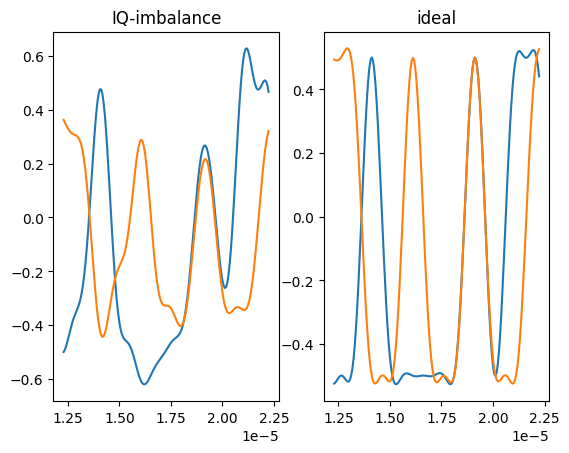

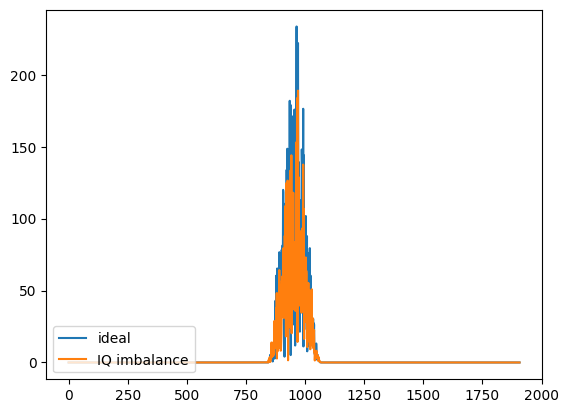

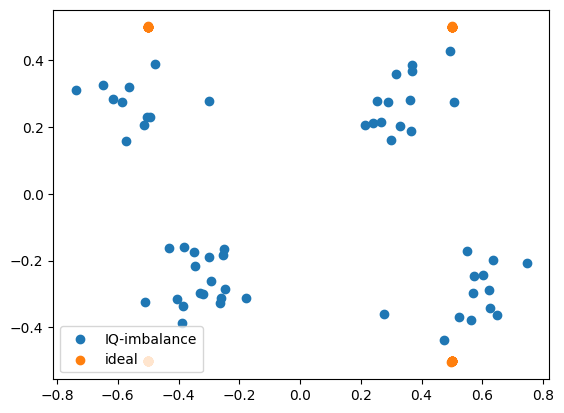

In [312]:
## demod
r_bb_i = s_bp*np.sqrt(2)*np.cos(2*np.pi*fc*t_new)
r_bb_q = -s_bp*np.sqrt(2)*np.sin(2*np.pi*fc*t_new) 

r_bb_ideal_i = s_bp_ideal*np.sqrt(2)*np.cos(2*np.pi*fc*t_new)
r_bb_ideal_q = -s_bp_ideal*np.sqrt(2)*np.sin(2*np.pi*fc*t_new)

#lp
h = 0

r_bb_ideal_i = np.convolve(filt,r_bb_ideal_i)
r_bb_ideal_q = np.convolve(filt,r_bb_ideal_q)
r_bb_i = np.convolve(filt,r_bb_i)
r_bb_q = np.convolve(filt,r_bb_q)

plt.figure()
plt.subplot(121)
plt.plot(t[K:K+10*n_up],r_bb_i[K:K+10*n_up],label="real")
plt.plot(t[K:K+10*n_up],r_bb_q[K:K+10*n_up],label="imag")
plt.title("IQ-imbalance")

plt.subplot(122)
plt.plot(t[K:K+10*n_up],r_bb_ideal_i[K:K+10*n_up],label="real")
plt.plot(t[K:K+10*n_up],r_bb_ideal_q[K:K+10*n_up],label="imag")
plt.title("ideal")


plt.figure()
spec = np.fft.fftshift(np.fft.fft(r_bb_ideal_i+1j*r_bb_ideal_q))
spec_IQim = np.fft.fftshift(np.fft.fft(r_bb_i+1j*r_bb_q))
plt.plot(np.abs(spec),label="ideal")
plt.plot(np.abs(spec_IQim),label="IQ imbalance")
plt.legend(loc=3)
plt.show()


plt.figure()
plt.scatter(r_bb_i[int(n_up+(K-1)/2):-4*K:n_up],r_bb_q[int(n_up+(K-1)/2):-4*K:n_up],label="IQ-imbalance")
plt.scatter(r_bb_ideal_i[int(n_up+(K-1)/2):-4*K:n_up],r_bb_ideal_q[int(n_up+(K-1)/2):-4*K:n_up],label="ideal")
plt.legend(loc=3)
plt.show()